# Datasets Download

- [https://www.kaggle.com/paultimothymooney/blood-cells/kernels](https://www.kaggle.com/paultimothymooney/blood-cells/kernels) 접속

- Download 버튼 클릭 -> Download

# DataSets

## 용어
- RBC : Red Blood Cell
- WBC : White Blood Cell

- NEUTROPHIL : 호중구
- EOSINOPHIL : 호산구
- MONOCYTE : 단핵구
- LYMPHOCYTE : 림프구

---

## 파일구조 살펴보기

### //dataset-master1

- dataset-master1 폴더에는 Annotations, JPEGImages 폴더가 2개 있다. Annotations 에는 xml파일이 있다. 아마 bounding box로 물체를 검출하는데 사용할 데이터셋으로 판단된다.

- xml 파일을 살펴볼때 RBC에 대한 bounding box만 존재한다. WBC가 없는 것을 보아 object detection 데이터셋이 조금 이상한 것 같다.

- 만약 object detection을 진행하려면 [이 곳](https://github.com/Shenggan/BCCD_Dataset/tree/master/BCCD)에서 데이터를 다시 받아야 한다.

### //dataset-master2

dataset-master2 폴더에는 이미지가 각 클래스 별로 폴더에 나누어져 있다. 그러므로 이미지를 분류하는 문제에서 사용할 데이터셋으로 판단된다. **실습은 분류문제를 해결하기 위해서 진행한다.**

In [12]:
import numpy as np
import os
import cv2
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [7]:
img_path = './blood-cells/dataset2-master/dataset2-master/images'
label_path = './blood-cells/dataset2-master/dataset2-master/labels.csv'

In [8]:
os.listdir(img_path)

['TEST', 'TEST_SIMPLE', 'TRAIN']

In [9]:
train_img_path = os.path.join(img_path, 'TRAIN')
test_img_path = os.path.join(img_path, 'TEST')
test_simple_img_path = os.path.join(img_path,'TEST_SIMPLE')

In [10]:
classes = os.listdir(train_img_path)

In [63]:
X_train = []
y_train = []
X_test = []
y_test = []

for i,cls in enumerate(classes):
    train_cls_path = os.path.join(train_img_path, cls)
    test_cls_path = os.path.join(test_img_path, cls)
    
    for file_name in os.listdir(train_cls_path):
        img_path = os.path.join(train_cls_path, file_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label = i

        X_train.append(img)
        y_train.append(i)
        
    for file_name in os.listdir(test_cls_path):
        img_path = os.path.join(test_cls_path, file_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label = i

        X_test.append(img)
        y_test.append(i)

In [64]:
X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [66]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(9957, 240, 320, 3)
(2487, 240, 320, 3)
(9957, 4)
(2487, 4)


In [67]:
import six
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape


def _bn_relu(x, bn_name=None, relu_name=None):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS, name=bn_name)(x)
    return Activation("relu", name=relu_name)(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu residual unit activation function.
       This is the original ResNet v1 scheme in https://arxiv.org/abs/1512.03385
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        x = Conv2D(filters=filters, kernel_size=kernel_size,
                   strides=strides, padding=padding,
                   dilation_rate=dilation_rate,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer,
                   name=conv_name)(x)
        return _bn_relu(x, bn_name=bn_name, relu_name=relu_name)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv residual unit with full pre-activation
    function. This is the ResNet v2 scheme proposed in
    http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        activation = _bn_relu(x, bn_name=bn_name, relu_name=relu_name)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      dilation_rate=dilation_rate,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name=conv_name)(activation)

    return f


def _shortcut(input_feature, residual, conv_name_base=None, bn_name_base=None):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input_feature)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input_feature
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        print('reshaping via a convolution...')
        if conv_name_base is not None:
            conv_name_base = conv_name_base + '1'
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001),
                          name=conv_name_base)(input_feature)
        if bn_name_base is not None:
            bn_name_base = bn_name_base + '1'
        shortcut = BatchNormalization(axis=CHANNEL_AXIS,
                                      name=bn_name_base)(shortcut)

    return add([shortcut, residual])


def _residual_block(block_function, filters, blocks, stage,
                    transition_strides=None, transition_dilation_rates=None,
                    dilation_rates=None, is_first_layer=False, dropout=None,
                    residual_unit=_bn_relu_conv):
    """Builds a residual block with repeating bottleneck blocks.
       stage: integer, current stage label, used for generating layer names
       blocks: number of blocks 'a','b'..., current block label, used for generating
            layer names
       transition_strides: a list of tuples for the strides of each transition
       transition_dilation_rates: a list of tuples for the dilation rate of each
            transition
    """
    if transition_dilation_rates is None:
        transition_dilation_rates = [(1, 1)] * blocks
    if transition_strides is None:
        transition_strides = [(1, 1)] * blocks
    if dilation_rates is None:
        dilation_rates = [1] * blocks

    def f(x):
        for i in range(blocks):
            is_first_block = is_first_layer and i == 0
            x = block_function(filters=filters, stage=stage, block=i,
                               transition_strides=transition_strides[i],
                               dilation_rate=dilation_rates[i],
                               is_first_block_of_first_layer=is_first_block,
                               dropout=dropout,
                               residual_unit=residual_unit)(x)
        return x

    return f


def _block_name_base(stage, block):
    """Get the convolution name base and batch normalization name base defined by
    stage and block.
    If there are less than 26 blocks they will be labeled 'a', 'b', 'c' to match the
    paper and keras and beyond 26 blocks they will simply be numbered.
    """
    if block < 27:
        block = '%c' % (block + 97)  # 97 is the ascii number for lowercase 'a'
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    return conv_name_base, bn_name_base


def basic_block(filters, stage, block, transition_strides=(1, 1),
                dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
                residual_unit=_bn_relu_conv):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input_features):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(3, 3),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_features)
        else:
            x = residual_unit(filters=filters, kernel_size=(3, 3),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_features)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        return _shortcut(input_features, x)

    return f


def bottleneck(filters, stage, block, transition_strides=(1, 1),
               dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
               residual_unit=_bn_relu_conv):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input_feature):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(1, 1),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_feature)
        else:
            x = residual_unit(filters=filters, kernel_size=(1, 1),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_feature)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters * 4, kernel_size=(1, 1),
                          conv_name_base=conv_name_base + '2c',
                          bn_name_base=bn_name_base + '2c')(x)

        return _shortcut(input_feature, x)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _string_to_function(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


def ResNet(input_shape=None, classes=10, block='bottleneck', residual_unit='v2',
           repetitions=None, initial_filters=64, activation='softmax', include_top=True,
           input_tensor=None, dropout=None, transition_dilation_rate=(1, 1),
           initial_strides=(2, 2), initial_kernel_size=(7, 7), initial_pooling='max',
           final_pooling=None, top='classification'):
    """Builds a custom ResNet like architecture. Defaults to ResNet50 v2.
    Args:
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` dim ordering)
            or `(3, 224, 224)` (with `channels_first` dim ordering).
            It should have exactly 3 dimensions,
            and width and height should be no smaller than 8.
            E.g. `(224, 224, 3)` would be one valid value.
        classes: The number of outputs at final softmax layer
        block: The block function to use. This is either `'basic'` or `'bottleneck'`.
            The original paper used `basic` for layers < 50.
        repetitions: Number of repetitions of various block units.
            At each block unit, the number of filters are doubled and the input size
            is halved. Default of None implies the ResNet50v2 values of [3, 4, 6, 3].
        residual_unit: the basic residual unit, 'v1' for conv bn relu, 'v2' for bn relu
            conv. See [Identity Mappings in
            Deep Residual Networks](https://arxiv.org/abs/1603.05027)
            for details.
        dropout: None for no dropout, otherwise rate of dropout from 0 to 1.
            Based on [Wide Residual Networks.(https://arxiv.org/pdf/1605.07146) paper.
        transition_dilation_rate: Dilation rate for transition layers. For semantic
            segmentation of images use a dilation rate of (2, 2).
        initial_strides: Stride of the very first residual unit and MaxPooling2D call,
            with default (2, 2), set to (1, 1) for small images like cifar.
        initial_kernel_size: kernel size of the very first convolution, (7, 7) for
            imagenet and (3, 3) for small image datasets like tiny imagenet and cifar.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        initial_pooling: Determine if there will be an initial pooling layer,
            'max' for imagenet and None for small image datasets.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        final_pooling: Optional pooling mode for feature extraction at the final
            model layer when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        top: Defines final layers to evaluate based on a specific problem type. Options
            are 'classification' for ImageNet style problems, 'segmentation' for
            problems like the Pascal VOC dataset, and None to exclude these layers
            entirely.
    Returns:
        The keras `Model`.
    """
    if activation not in ['softmax', 'sigmoid', None]:
        raise ValueError('activation must be one of "softmax", "sigmoid", or None')
    if activation == 'sigmoid' and classes != 1:
        raise ValueError('sigmoid activation can only be used when classes = 1')
    if repetitions is None:
        repetitions = [3, 4, 6, 3]
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)
    _handle_dim_ordering()
    if len(input_shape) != 3:
        raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

    if block == 'basic':
        block_fn = basic_block
    elif block == 'bottleneck':
        block_fn = bottleneck
    elif isinstance(block, six.string_types):
        block_fn = _string_to_function(block)
    else:
        block_fn = block

    if residual_unit == 'v2':
        residual_unit = _bn_relu_conv
    elif residual_unit == 'v1':
        residual_unit = _conv_bn_relu
    elif isinstance(residual_unit, six.string_types):
        residual_unit = _string_to_function(residual_unit)
    else:
        residual_unit = residual_unit

    # Permute dimension order if necessary
    if K.image_data_format() == 'channels_first':
        input_shape = (input_shape[1], input_shape[2], input_shape[0])
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    img_input = Input(shape=input_shape, tensor=input_tensor)
    x = _conv_bn_relu(filters=initial_filters, kernel_size=initial_kernel_size,
                      strides=initial_strides)(img_input)
    if initial_pooling == 'max':
        x = MaxPooling2D(pool_size=(3, 3), strides=initial_strides, padding="same")(x)

    block = x
    filters = initial_filters
    for i, r in enumerate(repetitions):
        transition_dilation_rates = [transition_dilation_rate] * r
        transition_strides = [(1, 1)] * r
        if transition_dilation_rate == (1, 1):
            transition_strides[0] = (2, 2)
        block = _residual_block(block_fn, filters=filters,
                                stage=i, blocks=r,
                                is_first_layer=(i == 0),
                                dropout=dropout,
                                transition_dilation_rates=transition_dilation_rates,
                                transition_strides=transition_strides,
                                residual_unit=residual_unit)(block)
        filters *= 2

    # Last activation
    x = _bn_relu(block)

    # Classifier block
    if include_top and top is 'classification':
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=classes, activation=activation,
                  kernel_initializer="he_normal")(x)
    elif include_top and top is 'segmentation':
        x = Conv2D(classes, (1, 1), activation='linear', padding='same')(x)

        if K.image_data_format() == 'channels_first':
            channel, row, col = input_shape
        else:
            row, col, channel = input_shape

        x = Reshape((row * col, classes))(x)
        x = Activation(activation)(x)
        x = Reshape((row, col, classes))(x)
    elif final_pooling == 'avg':
        x = GlobalAveragePooling2D()(x)
    elif final_pooling == 'max':
        x = GlobalMaxPooling2D()(x)

    model = Model(inputs=img_input, outputs=x)
    return model


def ResNet18(input_shape, classes):
    """ResNet with 18 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[2, 2, 2, 2])


def ResNet34(input_shape, classes):
    """ResNet with 34 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[3, 4, 6, 3])


def ResNet50(input_shape, classes):
    """ResNet with 50 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 4, 6, 3])


def ResNet101(input_shape, classes):
    """ResNet with 101 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 4, 23, 3])


def ResNet152(input_shape, classes):
    """ResNet with 152 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 8, 36, 3])

In [68]:
train_generator = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
)

test_generator = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
)

In [69]:
batch_size = 32
epochs = 100
lr = 0.01

In [70]:
train_data = train_generator.flow(X_train, y_train, batch_size=batch_size)
test_data = test_generator.flow(X_test, y_test, batch_size=batch_size)

In [71]:
model = ResNet18(inputs.shape[1:], len(classes))

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...


In [72]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 120, 160, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_43 (BatchNo (None, 120, 160, 64) 256         conv2d_41[0][0]                  
__________________________________________________________________________________________________
activation_35 (Activation)      (None, 120, 160, 64) 0           batch_normalization_43[0][0]     
__________________________________________________________________________________________________
max_poolin

In [76]:
from keras.optimizers import Adam

adam = Adam(lr=lr, decay=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [77]:
history = model.fit_generator(train_data, 
                              steps_per_epoch=16, 
                              epochs=epochs, 
                              validation_data=test_data,
                              validation_steps=5,
                              verbose=2)

Epoch 1/100


C:\Users\woals\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\woals\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\keras_preprocessing\image\image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 - 154s - loss: 4.0455 - acc: 0.2930 - val_loss: 15.2097 - val_acc: 0.2687
Epoch 2/100
 - 135s - loss: 5.0009 - acc: 0.3535 - val_loss: 15.8723 - val_acc: 0.2500
Epoch 3/100
 - 125s - loss: 5.1048 - acc: 0.3320 - val_loss: 6.3819 - val_acc: 0.2500
Epoch 4/100
 - 122s - loss: 4.8276 - acc: 0.3535 - val_loss: 4.9305 - val_acc: 0.3750
Epoch 5/100
 - 125s - loss: 4.4949 - acc: 0.3789 - val_loss: 4.2575 - val_acc: 0.4437
Epoch 6/100
 - 125s - loss: 4.2306 - acc: 0.3711 - val_loss: 4.0839 - val_acc: 0.4125
Epoch 7/100
 - 125s - loss: 4.0515 - acc: 0.3770 - val_loss: 4.0536 - val_acc: 0.3875
Epoch 8/100
 - 123s - loss: 3.9414 - acc: 0.3984 - val_loss: 3.9452 - val_acc: 0.2625
Epoch 9/100
 - 123s - loss: 3.9094 - acc: 0.3027 - val_loss: 3.6681 - val_acc: 0.4250
Epoch 10/100
 - 123s - loss: 3.6909 - acc: 0.3613 - val_loss: 3.5739 - val_acc: 0.4313
Epoch 11/100
 - 122s - loss: 3.7141 - acc: 0.3750 - val_loss: 3.4937 - val_acc: 0.4062
Epoch 12/100
 - 124s - loss: 3.5856 - acc: 0.3906 - val_loss: 

Epoch 96/100
 - 122s - loss: 2.1258 - acc: 0.5957 - val_loss: 2.7070 - val_acc: 0.4437
Epoch 97/100
 - 123s - loss: 2.1019 - acc: 0.5820 - val_loss: 2.6318 - val_acc: 0.4562
Epoch 98/100
 - 116s - loss: 2.2226 - acc: 0.5666 - val_loss: 2.4371 - val_acc: 0.5375
Epoch 99/100
 - 122s - loss: 2.1118 - acc: 0.6523 - val_loss: 2.7151 - val_acc: 0.3500
Epoch 100/100
 - 122s - loss: 2.1161 - acc: 0.6094 - val_loss: 2.5648 - val_acc: 0.4813


In [78]:
model.save('blood_cell_cls_resnet18.h5')

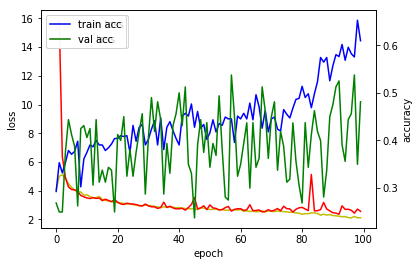

In [83]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [84]:
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=32)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

2487/2487 [==============================] - 147s 59ms/step
## evaluation loss and_metrics ##
[2.665285412259595, 0.40369923607527514]


In [85]:
from keras import backend as K

K.tensorflow_backend._get_available_gpus()

[]